In [4]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

In [6]:
path = '/Users/shrutisekhar/Desktop/icg project/facades/train/'
# load dataset
[tar_images, in_images] = load_images(path)
print('Loaded: ', 'target image shape-',tar_images.shape, 'input image shape-',in_images.shape)

Loaded:  target image shape- (400, 256, 256, 3) input image shape- (400, 256, 256, 3)


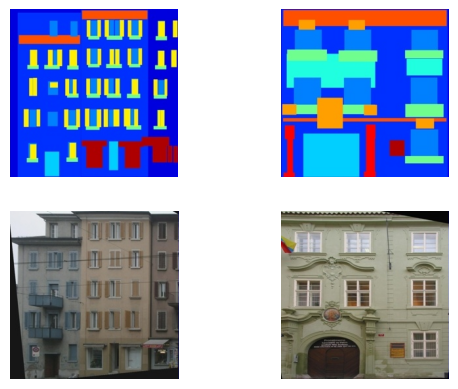

In [7]:

for i in range(2):
	plt.subplot(2, 2, 1 + i)
	plt.axis('off')
	plt.imshow(in_images[i].astype('uint8'))
# plot target image
for i in range(2):
	plt.subplot(2, 2, 3 + i)
	plt.axis('off')
	plt.imshow(tar_images[i].astype('uint8'))
plt.show()

In [8]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model


In [9]:
def define_discriminator(image_shape): 
	#patchGAN architecture
    
	# weight initialization
	init = RandomNormal(stddev=0.02) 
    
	# source image input
	in_src_image = Input(shape=image_shape) 
	# target image input
	in_target_image = Input(shape=image_shape)  
    
	# concatenate images
	merged = Concatenate()([in_src_image, in_target_image]) #it will have 6 channels (3 for src and 3 for target)


    #following pix2pix paper architecture
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)

	model = Model([in_src_image, in_target_image], patch_out)
    
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=0.5)
	return model

In [10]:
def encoder_block(layer_in, n_filters, batchnorm=True):
	
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	if batchnorm:
		g = BatchNormalization()(g, training=True)
	
	g = LeakyReLU(alpha=0.2)(g)
	return g
def decoder_block(layer_in, skip_in, n_filters, dropout=True):

    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
     g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g


In [11]:
def define_generator(image_shape=(256,256,3)): 

    init = RandomNormal(stddev=0.02)
 
    in_image = Input(shape=image_shape)
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) 
    out_image = Activation('tanh')(g)  

    model = Model(in_image, out_image)
    return model

In [12]:
def pix2pix_gan(g_model, d_model, image_shape=(256,256,3)):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    
    #source img is input to generator
    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src) 

    # input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # source image as input, generated image and discriminator output as outputs
    model = Model(in_src, [dis_out, gen_out])
   
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model
     

In [13]:
def generate_real_samples(dataset, n_samples, patch_shape):
	
	train_in, train_tar = dataset #the input and corresponding target img
	ix = randint(0, train_in.shape[0], n_samples)
	X1, X2 = train_in[ix], train_tar[ix] 
	
	# label 1 for randomly selected real sample
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [14]:
def generate_fake_samples(g_model, samples, patch_shape):

	X = g_model.predict(samples) 
	
	# label 0 for fake sample generated by generator
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y


In [15]:
import os

In [16]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = os.path.join('/Users/shrutisekhar/Desktop/icg project/storage','plot_%06d.png' % (step+1))
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = os.path.join('/Users/shrutisekhar/Desktop/icg project/storage','model_%06d.h5' % (step+1))
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


In [17]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	
	for i in range(n_steps):
		#generate real and fake samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
	
		#train discriminator
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake) 
		
		# update the generator
		g_loss, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		
		summarize_performance(i, g_model, dataset)

In [ ]:
image_shape = in_images.shape[1:]

d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = pix2pix_gan(g_model, d_model, image_shape)

data = [in_images, tar_images]

def preprocess_data(data):
	
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1) 


stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)




In [20]:
from matplotlib import pyplot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


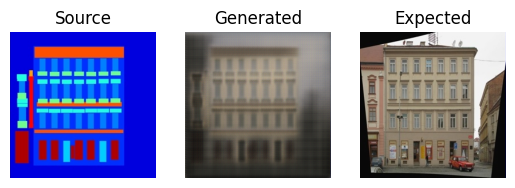

In [23]:
from keras.models import load_model
from numpy.random import randint
model = load_model('/Users/shrutisekhar/Desktop/icg project/storage/model_000790.h5')

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()


data = [in_images, tar_images]
dataset = preprocess_data(data)
[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images 

plot_images(src_image, gen_image, tar_image)